# Overall price 

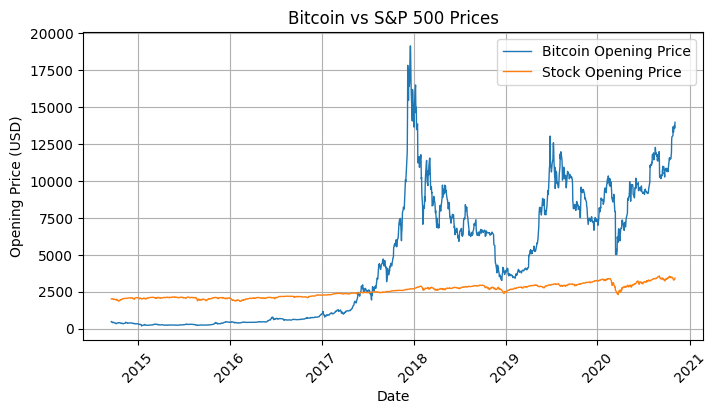

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

prices = pd.read_csv('./Processed/combined_prices.csv')

prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')
prices.set_index('Date', inplace=True)


plt.figure(figsize=(8, 4)) 
plt.plot(prices.index, prices['Open_B'], label='Bitcoin Opening Price', linewidth=1)
plt.plot(prices.index, prices['Open_S'], label='Stock Opening Price', linewidth=1)

plt.title('Bitcoin vs S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.show()

Epoch 1/20


/Users/joaomarujo/Documents/StockBTC-Sentiment-Price/.venv310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0516 - val_loss: 0.0087
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6143e-04 - val_loss: 0.0011
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1519e-04 - val_loss: 0.0011
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8001e-04 - val_l

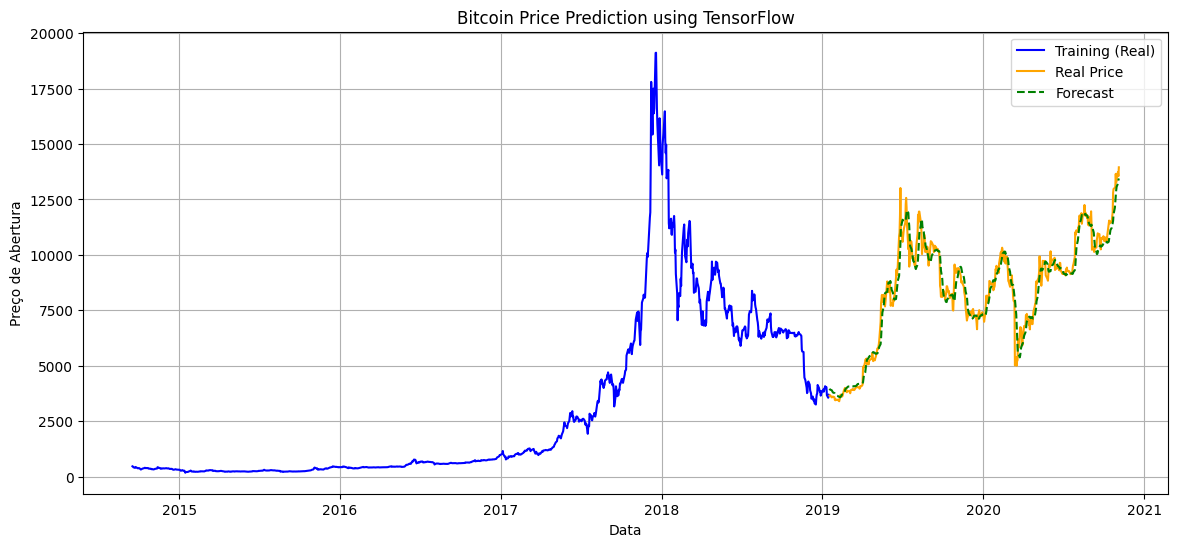

In [4]:
prices.reset_index(inplace=True)
prices = prices[['Date', 'Open_B']].dropna()
#prices = prices[prices['Date'] >= '2016-01-01'].reset_index(drop=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(prices[['Open_B']])
prices['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(prices['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(prices['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(prices['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(prices['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(prices['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Bitcoin Price Prediction using TensorFlow')
plt.xlabel('Data')
plt.ylabel('Preço de Abertura')
plt.legend()
plt.grid()
plt.show()


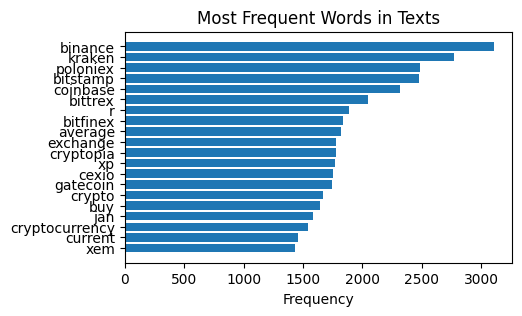

<bound method NDFrame.tail of             Date                                               body
0     2018-01-07                    [jan, £, pictwittercomwwtqauyx]
1     2018-01-07  [cotización, del, cash, kraken, bitcoincash, k...
2     2018-01-07  [btcusd, touché, à, hier, bas, à, gmt, market,...
3     2018-01-07  [ocak, saat, kaç, tl, tl, bitcointl, btctry, b...
4     2018-01-07  [coinbase, eur, eur, h, ago, cryptocurrency, t...
...          ...                                                ...
24795 2018-02-06                                      [bi, te, cek]
24796 2018-02-06  [bittrex, bot, profit, sell, lun, ƀ, profit, ƀ...
24797 2018-02-06  [envío, de, coinbase, trezor, aplazado, hora, ...
24798 2018-02-06        [bubble, bitcoincrashpictwittercomqtenffbh]
24799 2018-02-06  [reuters, topic, newtop, story, senate, spotli...

[24800 rows x 2 columns]>

In [3]:
from collections import Counter

visu_words = pd.read_pickle('visu_words.pkl')

word_counter = Counter()

for tokens in visu_words['body']:
    word_counter.update(tokens)

words, counts = zip(*word_counter.most_common(20))

plt.figure(figsize=(5, 3))
plt.barh(words[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title('Most Frequent Words in Texts')
plt.show()
visu_words.tail
